### This script does basic bhv quantifications
#### this script runs DLC and quantifies the gazes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import scipy.stats as st
from sklearn.neighbors import KernelDensity
from sklearn.linear_model import LinearRegression
import string
import warnings
import pickle

import os
import glob
import random
from time import time

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - get body part location for each pair of cameras

In [3]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [4]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [5]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [6]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody

### function - define time point of behavioral events

In [7]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [8]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [9]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [10]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network - multi time lag (3 lags)

In [12]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)
### separate each session based on trial types (different force levels)

In [102]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# frame number of the demo video
# nframes = 0.5*30 # second*30fps
nframes = 1*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# only analyze the best (five) sessions for each conditions
do_bestsession = 1
if do_bestsession:
    savefile_sufix = '_bestsessions'
else:
    savefile_sufix = '_allsessions'
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

# force manipulation type
# SR_bothchange: self reward, both forces changed
# CO_bothchange: 1s cooperation, both forces changed
# CO_A1change: 1s cooperation, animal 1 forces changed
# CO_A2change: 1s cooperation, animal 2 forces changed
forceManiType = 'CO_A1change'

# Koala Vermelho
if 1:
    if do_bestsession:      
        # both animals' lever force were changed - Self reward
        if forceManiType == 'SR_bothchange':
            dates_list = [ "20240228","20240229","20240409","20240411",
                           "20240412","20240416","20240419",] 
            session_start_times = [ 64.5,  73.5,  0.00,  0.00,  
                                    0.00,  0.00,  0.00,  ] # in second
        # both animals' lever force were changed - cooperation
        elif forceManiType == 'CO_bothchange':
            dates_list = [ "20240304", ]
            session_start_times = [ 0.00, ] # in second
        # Koala's lever force were changed
        if forceManiType == 'CO_A1change':
            dates_list = [ "20240305","20240306","20240313","20240318","20240321",
                           "20240426","20240429","20240430"]
            session_start_times = [ 62.0,  55.2,  0.00,  0.00,  0.00, 
                                    0.00,  0.00,  0.00,  ] # in second
        # Verm's lever force were changed
        if forceManiType == 'CO_A2change':
            dates_list = [ "20240307","20240308","20240311","20240319",
                           "20240320","20240422","20240423","20240425",]
            session_start_times = [ 72.2,  0.00,  60.8,  0.00,  
                                    0.00,  53.0,  0.00,  0.00,] # in second       
    
    elif not do_bestsession:
        # pick only five sessions for each conditions
        dates_list = [
                      # both animals' lever force were changed - Self reward
                    #  "20240228","20240229","20240409","20240411",
                    #  "20240412","20240416","20240419",
                      # both animals' lever force were changed - cooperation
                    #  "20240304",
                      # Koala's lever force were changed
                      "20240305","20240306","20240313","20240318","20240321",
                      "20240426","20240429","20240429",
                      # Verm's lever force were changed
                      "20240307","20240308","20240311","20240319",
                      "20240320","20240422","20240423","20240425",
                     ]
        session_start_times = [ 
                                # both animals' lever force were changed - Self reward
                        #        64.5,  73.5,  0.00,  0.00,  
                        #        0.00,  0.00,  0.00, 
                                # both animals' lever force were changed - cooperation
                        #        0.00,  
                                # Koala's lever force were changed
                                62.0,  55.2,  0.00,  0.00,  0.00, 
                                0.00,  0.00,  0.00,
                                # Verm's lever force were changed
                                72.2,  0.00,  60.8,  0.00,  
                                0.00,  53.0,  0.00,  0.00,
                              ] # in second
    
    animal1_fixedorder = ['koala']
    animal2_fixedorder = ['vermelho']

    animal1_filename = "Koala"
    animal2_filename = "Vermelho"
    
#    
# dates_list = ["20240430"]
# session_start_times = [0.00] # in second
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'


# location of levers and tubes for camera 2
# get this information using DLC animal tracking GUI, the results are stored: 
# /home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_with_lever_tube-weikang-2023-04-13/labeled-data/
considerlevertube = 1
considertubeonly = 0
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables  
# align the animal1 and animal2 across the sessions
animal1_name_all_dates = np.empty(shape=(0,), dtype=str)
animal2_name_all_dates = np.empty(shape=(0,), dtype=str)
trialdates_all_dates = np.empty(shape=(0,), dtype=str)
tasktypes_all_dates = np.zeros((0,))
coopthres_all_dates = np.zeros((0,))
force1_all_dates = np.zeros((0,)) 
force2_all_dates = np.zeros((0,)) 

subblockID_all_dates = np.zeros((0,))

succ_rate_all_dates = np.zeros((0,))
trialnum_all_dates = np.zeros((0,))
blocktime_all_dates = np.zeros((0,))

interpullintv_all_dates = np.zeros((0,))
pull1_IPI_all_dates = np.zeros((0,))
pull2_IPI_all_dates = np.zeros((0,))
pull1_IPI_std_all_dates = np.zeros((0,))
pull2_IPI_std_all_dates = np.zeros((0,))

owgaze1_num_all_dates = np.zeros((0,))
owgaze2_num_all_dates = np.zeros((0,))
mtgaze1_num_all_dates = np.zeros((0,))
mtgaze2_num_all_dates = np.zeros((0,))
pull1_num_all_dates = np.zeros((0,))
pull2_num_all_dates = np.zeros((0,))

lever1_holdtime_all_dates = np.zeros((0,))
lever2_holdtime_all_dates = np.zeros((0,))
lever1_holdtime_std_all_dates = np.zeros((0,))
lever2_holdtime_std_all_dates = np.zeros((0,))

lever1_gauge_all_dates = np.zeros((0,))
lever2_gauge_all_dates = np.zeros((0,))
lever1_gauge_std_all_dates = np.zeros((0,))
lever2_gauge_std_all_dates = np.zeros((0,))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_forceManipulation_task_data_saved/'


    

In [103]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
   
    with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        animal1_name_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        animal2_name_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        trialdates_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        force1_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        force2_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        subblockID_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        blocktime_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_IPI_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_IPI_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_IPI_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_IPI_std_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)     
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/lever1_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_holdtime_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever1_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_holdtime_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_holdtime_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_holdtime_std_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/lever1_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_gauge_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever1_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever1_gauge_std_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_gauge_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/lever2_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        lever2_gauge_std_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)

    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]
        
        # load behavioral results
        try:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_lever_reading_" + "*.json") 
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            lever_reading = pd.read_json(lever_reading_json[0])
        except:
            bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_forceManipulation_task/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            lever_reading_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_lever_reading_" + "*.json")             
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            lever_reading = pd.read_json(lever_reading_json[0])

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = bhv_data["trial_number"]==itrial+1
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        # change lever reading time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(lever_reading)[0]),columns=["time_points_new"])
        for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
            ind = lever_reading["trial_number"]==itrial+1
            new_time_itrial = lever_reading[ind]["readout_timepoint"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        lever_reading["readout_timepoint"] = time_points_new["time_points_new"]
        lever_reading = lever_reading[lever_reading["readout_timepoint"] != 0]
        #
        lever1_pull = lever_reading[(lever_reading['lever_id']==1)&(lever_reading['pull_or_release']==1)]
        lever1_release = lever_reading[(lever_reading['lever_id']==1)&(lever_reading['pull_or_release']==0)]
        lever2_pull = lever_reading[(lever_reading['lever_id']==2)&(lever_reading['pull_or_release']==1)]
        lever2_release = lever_reading[(lever_reading['lever_id']==2)&(lever_reading['pull_or_release']==0)]
        #
        if np.shape(lever1_release)[0]<np.shape(lever1_pull)[0]:
            lever1_pull = lever1_pull.iloc[0:-1]
        if np.shape(lever2_release)[0]<np.shape(lever2_pull)[0]:
            lever2_pull = lever2_pull.iloc[0:-1]
        #
        lever1_pull_release = lever1_pull
        lever1_pull_release['delta_timepoint'] = np.array(lever1_release['readout_timepoint'].reset_index(drop=True)-lever1_pull['readout_timepoint'].reset_index(drop=True))
        lever1_pull_release['delta_gauge'] = np.array(lever1_release['strain_gauge'].reset_index(drop=True)-lever1_pull['strain_gauge'].reset_index(drop=True))
        lever2_pull_release = lever2_pull
        lever2_pull_release['delta_timepoint'] = np.array(lever2_release['readout_timepoint'].reset_index(drop=True)-lever2_pull['readout_timepoint'].reset_index(drop=True))
        lever2_pull_release['delta_gauge'] = np.array(lever2_release['strain_gauge'].reset_index(drop=True)-lever2_pull['strain_gauge'].reset_index(drop=True))
        
        
        # load behavioral event results from the tracking analysis
        if 1:
            # folder and file path
            camera12_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_forceManipulation_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
            camera23_analyzed_path = "/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/test_video_forceManipulation_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"

            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
            try: 
                bodyparts_camI_camIJ = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
                video_file_original = camera12_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
            except:
                bodyparts_camI_camIJ = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
                # get the bodypart data from files
                bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,date_tgt)
                video_file_original = camera23_analyzed_path+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        

            try:
                # dummy
                print('load social gaze with '+cameraID+' only of '+date_tgt)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                    output_look_ornot = pickle.load(f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                    output_allvectors = pickle.load(f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                    output_allangles = pickle.load(f)  
            except:   
                print('analyze social gaze with '+cameraID+' only of '+date_tgt)
                # get social gaze information 
                output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                       considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                       sqr_thres_face,sqr_thres_body)
                # save data
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                    pickle.dump(output_look_ornot, f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                    pickle.dump(output_allvectors, f)
                with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                    pickle.dump(output_allangles, f)


            look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
            look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
            look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
            # change the unit to second
            session_start_time = session_start_times[idate]
            look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
            look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 

            # find time point of behavioral events
            output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
            time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
            time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
            oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
            oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
            mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
            mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']


            # # plot behavioral events
            if np.isin(animal1,animal1_fixedorder):
                    plot_bhv_events(date_tgt,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                    plot_bhv_events(date_tgt,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            #
            # save behavioral events plot
            if 1:
                current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                plt.savefig(data_saved_folder+"/bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/'+date_tgt+"_"+cameraID_short+".pdf")
                

            # analyze the events interval, especially for the pull to other and other to pull interval
            # could be used for define time bin for DBN
            if 1:
                _,_,_,pullTOother_itv, otherTOpull_itv = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, 
                                                                             oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                #
                pull_other_pool_itv = np.concatenate((pullTOother_itv,otherTOpull_itv))
                bhv_intv_all_dates[date_tgt] = {'pull_to_other':pullTOother_itv,'other_to_pull':otherTOpull_itv,
                                'pull_other_pooled': pull_other_pool_itv}

            # plot the tracking demo video
            if 0: 
                tracking_video_singlecam_wholebody_demo(bodyparts_locs_camI,output_look_ornot,output_allvectors,output_allangles,
                                                  lever_locs_camI,tube_locs_camI,time_point_pull1,time_point_pull2,
                                                  animalnames_videotrack,bodypartnames_videotrack,date_tgt,
                                                  animal1_filename,animal2_filename,session_start_time,fps,nframes,cameraID,
                                                  video_file_original,sqr_thres_tubelever,sqr_thres_face,sqr_thres_body)         
        
             
            
        # after all the analysis, separate them based on different subblock    
        # get task type and cooperation threshold
        # tasktype: 1-normal SR, 2-force changed SR, 3-normal coop, 4-force changed coop
        trialID_list = np.array(trial_record_clean['trial_number'],dtype = 'int')
        tasktype_list = np.array(trial_record_clean['task_type'],dtype = 'int')
        coop_thres_list = np.array(trial_record_clean['pulltime_thres'],dtype = 'int')
        lever1force_list = np.array(trial_record_clean['lever1_force'],dtype = 'int')
        lever2force_list = np.array(trial_record_clean['lever2_force'],dtype = 'int')
        
        # use the combination of lever 1/2 forces to separate trials
        force12_uniques,indices = np.unique(np.vstack((lever1force_list,lever2force_list)),axis=1,return_index=True)
        force12_uniques = force12_uniques[:,np.argsort(indices)]
        ntrialtypes = np.shape(force12_uniques)[1]
        
        # 
        for itrialtype in np.arange(0,ntrialtypes,1):
            force1_unique = force12_uniques[0,itrialtype]
            force2_unique = force12_uniques[1,itrialtype]

            ind = np.isin(lever1force_list,force1_unique) & np.isin(lever2force_list,force2_unique)
            
            trialID_itrialtype = trialID_list[ind]
            
            tasktype_itrialtype = np.unique(tasktype_list[ind])
            coop_thres_itrialtype = np.unique(coop_thres_list[ind])
            
            # save some simple measures
            animal1_name_all_dates = np.append(animal1_name_all_dates,animal1)
            animal2_name_all_dates = np.append(animal2_name_all_dates,animal2)
            trialdates_all_dates = np.append(trialdates_all_dates,date_tgt)
            tasktypes_all_dates = np.append(tasktypes_all_dates,tasktype_itrialtype)
            coopthres_all_dates = np.append(coopthres_all_dates,coop_thres_itrialtype)
            #
            if np.isin(animal1,animal1_fixedorder):
                force1_all_dates = np.append(force1_all_dates,force1_unique)
                force2_all_dates = np.append(force2_all_dates,force2_unique)
            else:
                force1_all_dates = np.append(force1_all_dates,force2_unique)
                force2_all_dates = np.append(force2_all_dates,force1_unique)
            #
            trialnum_all_dates = np.append(trialnum_all_dates,np.sum(ind))
            subblockID_all_dates = np.append(subblockID_all_dates,itrialtype)
            
            # analyze behavior results
            bhv_data_itrialtype = bhv_data[np.isin(bhv_data['trial_number'],trialID_itrialtype)]
            #
            # successful rates
            succ_rate_itrialtype = np.sum((bhv_data_itrialtype['behavior_events']==3)|(bhv_data_itrialtype['behavior_events']==4))/np.sum((bhv_data_itrialtype['behavior_events']==1)|(bhv_data_itrialtype['behavior_events']==2))
            succ_rate_all_dates = np.append(succ_rate_all_dates,succ_rate_itrialtype)
            #
            # block time
            block_starttime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==0]['time_points'].iloc[0]
            block_endtime = bhv_data_itrialtype[bhv_data_itrialtype['behavior_events']==9]['time_points'].iloc[-1]
            blocktime_all_dates = np.append(blocktime_all_dates,block_endtime-block_starttime)
            #
            # across animal interpull interval
            pullid = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1) | (bhv_data_itrialtype['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1) | (bhv_data_itrialtype['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<20]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates = np.append(interpullintv_all_dates,mean_interpull_intv)
            # 
            # animal 1 and 2's pull numbers
            if np.isin(animal1,animal1_fixedorder):
                pull1_num_all_dates = np.append(pull1_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==1))
                pull2_num_all_dates = np.append(pull2_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==2))
            else:
                pull1_num_all_dates = np.append(pull1_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==2))
                pull2_num_all_dates = np.append(pull2_num_all_dates,np.sum(bhv_data_itrialtype['behavior_events']==1))
            #
            # animal 1 and 2's within animal interpull interval
            pull1time = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==1)]["time_points"])
            ipi_pull1 = pull1time[1:]-pull1time[0:-1]
            ipi_pull1 = ipi_pull1[ipi_pull1<20]
            mean_ipi_pull1 = np.nanmean(ipi_pull1)
            std_ipi_pull1 = np.nanstd(ipi_pull1)/np.sqrt(np.shape(ipi_pull1)[0])
            pull2time = np.array(bhv_data_itrialtype[(bhv_data_itrialtype['behavior_events']==2)]["time_points"])
            ipi_pull2 = pull2time[1:]-pull2time[0:-1]
            ipi_pull2 = ipi_pull2[ipi_pull2<20]
            mean_ipi_pull2 = np.nanmean(ipi_pull2)
            std_ipi_pull2 = np.nanstd(ipi_pull2)/np.sqrt(np.shape(ipi_pull2)[0])
            if np.isin(animal1,animal1_fixedorder):
                pull1_IPI_all_dates = np.append(pull1_IPI_all_dates,mean_ipi_pull1)
                pull2_IPI_all_dates = np.append(pull2_IPI_all_dates,mean_ipi_pull2)
                pull1_IPI_std_all_dates = np.append(pull1_IPI_std_all_dates,std_ipi_pull1)
                pull2_IPI_std_all_dates = np.append(pull2_IPI_std_all_dates,std_ipi_pull2)
            else:
                pull1_IPI_all_dates = np.append(pull1_IPI_all_dates,mean_ipi_pull2)
                pull2_IPI_all_dates = np.append(pull2_IPI_all_dates,mean_ipi_pull1)
                pull1_IPI_std_all_dates = np.append(pull1_IPI_std_all_dates,std_ipi_pull2)
                pull2_IPI_std_all_dates = np.append(pull2_IPI_std_all_dates,std_ipi_pull1)
            
            
            # lever holding time            
            lever1_holdtimes_itrialtype = lever1_pull_release[np.isin(lever1_pull_release['trial_number'],trialID_itrialtype)]['delta_timepoint']
            mean_lever1_holdtime = np.nanmean(lever1_holdtimes_itrialtype)           
            std_lever1_holdtime = np.nanstd(lever1_holdtimes_itrialtype)/np.sqrt(np.shape(lever1_holdtimes_itrialtype)[0]) 
            lever2_holdtimes_itrialtype = lever2_pull_release[np.isin(lever2_pull_release['trial_number'],trialID_itrialtype)]['delta_timepoint']
            mean_lever2_holdtime = np.nanmean(lever2_holdtimes_itrialtype)
            std_lever2_holdtime = np.nanstd(lever2_holdtimes_itrialtype)/np.sqrt(np.shape(lever2_holdtimes_itrialtype)[0])             
            if np.isin(animal1,animal1_fixedorder):
                lever1_holdtime_all_dates = np.append(lever1_holdtime_all_dates,mean_lever1_holdtime)
                lever2_holdtime_all_dates = np.append(lever2_holdtime_all_dates,mean_lever2_holdtime)
                lever1_holdtime_std_all_dates = np.append(lever1_holdtime_std_all_dates,std_lever1_holdtime)
                lever2_holdtime_std_all_dates = np.append(lever2_holdtime_std_all_dates,std_lever2_holdtime)
            else:
                lever1_holdtime_all_dates = np.append(lever1_holdtime_all_dates,mean_lever2_holdtime)
                lever2_holdtime_all_dates = np.append(lever2_holdtime_all_dates,mean_lever1_holdtime)
                lever1_holdtime_std_all_dates = np.append(lever1_holdtime_std_all_dates,std_lever2_holdtime)
                lever2_holdtime_std_all_dates = np.append(lever2_holdtime_std_all_dates,std_lever1_holdtime)
            
            # strain gauge reading
            lever1_gauge_itrialtype = lever1_pull_release[np.isin(lever1_pull_release['trial_number'],trialID_itrialtype)]['delta_gauge']
            mean_lever1_gauge = np.nanmean(lever1_gauge_itrialtype)           
            std_lever1_gauge = np.nanstd(lever1_gauge_itrialtype)/np.sqrt(np.shape(lever1_gauge_itrialtype)[0]) 
            lever2_gauge_itrialtype = lever2_pull_release[np.isin(lever2_pull_release['trial_number'],trialID_itrialtype)]['delta_gauge']
            mean_lever2_gauge = np.nanmean(lever2_gauge_itrialtype)
            std_lever2_gauge = np.nanstd(lever2_gauge_itrialtype)/np.sqrt(np.shape(lever2_gauge_itrialtype)[0])             
            if np.isin(animal1,animal1_fixedorder):
                lever1_gauge_all_dates = np.append(lever1_gauge_all_dates,mean_lever1_gauge)
                lever2_gauge_all_dates = np.append(lever2_gauge_all_dates,mean_lever2_gauge)
                lever1_gauge_std_all_dates = np.append(lever1_gauge_std_all_dates,std_lever1_gauge)
                lever2_gauge_std_all_dates = np.append(lever2_gauge_std_all_dates,std_lever2_gauge)
            else:
                lever1_gauge_all_dates = np.append(lever1_gauge_all_dates,mean_lever2_gauge)
                lever2_gauge_all_dates = np.append(lever2_gauge_all_dates,mean_lever1_gauge)
                lever1_gauge_std_all_dates = np.append(lever1_gauge_std_all_dates,std_lever2_gauge)
                lever2_gauge_std_all_dates = np.append(lever2_gauge_std_all_dates,std_lever1_gauge)

            
            # gaze number, based on the DLC tracking 
            if np.isin(animal1,animal1_fixedorder):
                owgaze1_num_all_dates = np.append(owgaze1_num_all_dates,np.shape(oneway_gaze1[(oneway_gaze1<=block_endtime)&(oneway_gaze1>=block_starttime)])[0])
                owgaze2_num_all_dates = np.append(owgaze2_num_all_dates,np.shape(oneway_gaze2[(oneway_gaze2<=block_endtime)&(oneway_gaze2>=block_starttime)])[0])
                mtgaze1_num_all_dates = np.append(mtgaze1_num_all_dates,np.shape(mutual_gaze1[(mutual_gaze1<=block_endtime)&(mutual_gaze1>=block_starttime)])[0])
                mtgaze2_num_all_dates = np.append(mtgaze2_num_all_dates,np.shape(mutual_gaze2[(mutual_gaze2<=block_endtime)&(mutual_gaze2>=block_starttime)])[0])
            else:
                owgaze1_num_all_dates = np.append(owgaze1_num_all_dates,np.shape(oneway_gaze2[(oneway_gaze2<=block_endtime)&(oneway_gaze2>=block_starttime)])[0])
                owgaze2_num_all_dates = np.append(owgaze2_num_all_dates,np.shape(oneway_gaze1[(oneway_gaze1<=block_endtime)&(oneway_gaze1>=block_starttime)])[0])
                mtgaze1_num_all_dates = np.append(mtgaze1_num_all_dates,np.shape(mutual_gaze2[(mutual_gaze2<=block_endtime)&(mutual_gaze2>=block_starttime)])[0])
                mtgaze2_num_all_dates = np.append(mtgaze2_num_all_dates,np.shape(mutual_gaze1[(mutual_gaze1<=block_endtime)&(mutual_gaze1>=block_starttime)])[0])
            
            
                
    # save data
    if 1:        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        with open(data_saved_subfolder+'/animal1_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(animal1_name_all_dates, f)
        with open(data_saved_subfolder+'/animal2_name_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(animal2_name_all_dates, f)
        with open(data_saved_subfolder+'/trialdates_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(trialdates_all_dates, f)
        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
            
        with open(data_saved_subfolder+'/force1_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(force1_all_dates, f)
        with open(data_saved_subfolder+'/force2_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(force2_all_dates, f)
            
        with open(data_saved_subfolder+'/subblockID_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(subblockID_all_dates, f)
            
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/blocktime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(blocktime_all_dates, f)
        
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/pull1_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_IPI_all_dates, f)
        with open(data_saved_subfolder+'/pull1_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_IPI_std_all_dates, f)
        with open(data_saved_subfolder+'/pull2_IPI_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_IPI_all_dates, f)
        with open(data_saved_subfolder+'/pull2_IPI_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_IPI_std_all_dates, f)
                
        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)       
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open(data_saved_subfolder+'/lever1_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_holdtime_all_dates, f)
        with open(data_saved_subfolder+'/lever1_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_holdtime_std_all_dates, f)
        with open(data_saved_subfolder+'/lever2_holdtime_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_holdtime_all_dates, f)
        with open(data_saved_subfolder+'/lever2_holdtime_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_holdtime_std_all_dates, f)
        
        with open(data_saved_subfolder+'/lever1_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_gauge_all_dates, f)
        with open(data_saved_subfolder+'/lever1_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever1_gauge_std_all_dates, f)
        with open(data_saved_subfolder+'/lever2_gauge_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_gauge_all_dates, f)
        with open(data_saved_subfolder+'/lever2_gauge_std_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(lever2_gauge_std_all_dates, f)
              
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
    

all data from all dates are loaded


In [104]:
np.max((owgaze1_num_all_dates+mtgaze1_num_all_dates)/blocktime_all_dates)

6.828332664156743

In [105]:
owgaze2_num_all_dates

array([ 1.,  0., 52.,  0.,  5., 34., 13., 17.,  9.,  0.,  3.,  1.,  0.,
       13.,  1.,  0., 45., 11.,  0., 32., 17.,  4., 10., 24.,  5., 12.,
        0., 17.,  3.])

### plot 
#### tasktype: 1-normal SR, 2-force changed SR, 3-normal coop, 4-force changed coop
#### plot against force1, force2, or the subblock ID

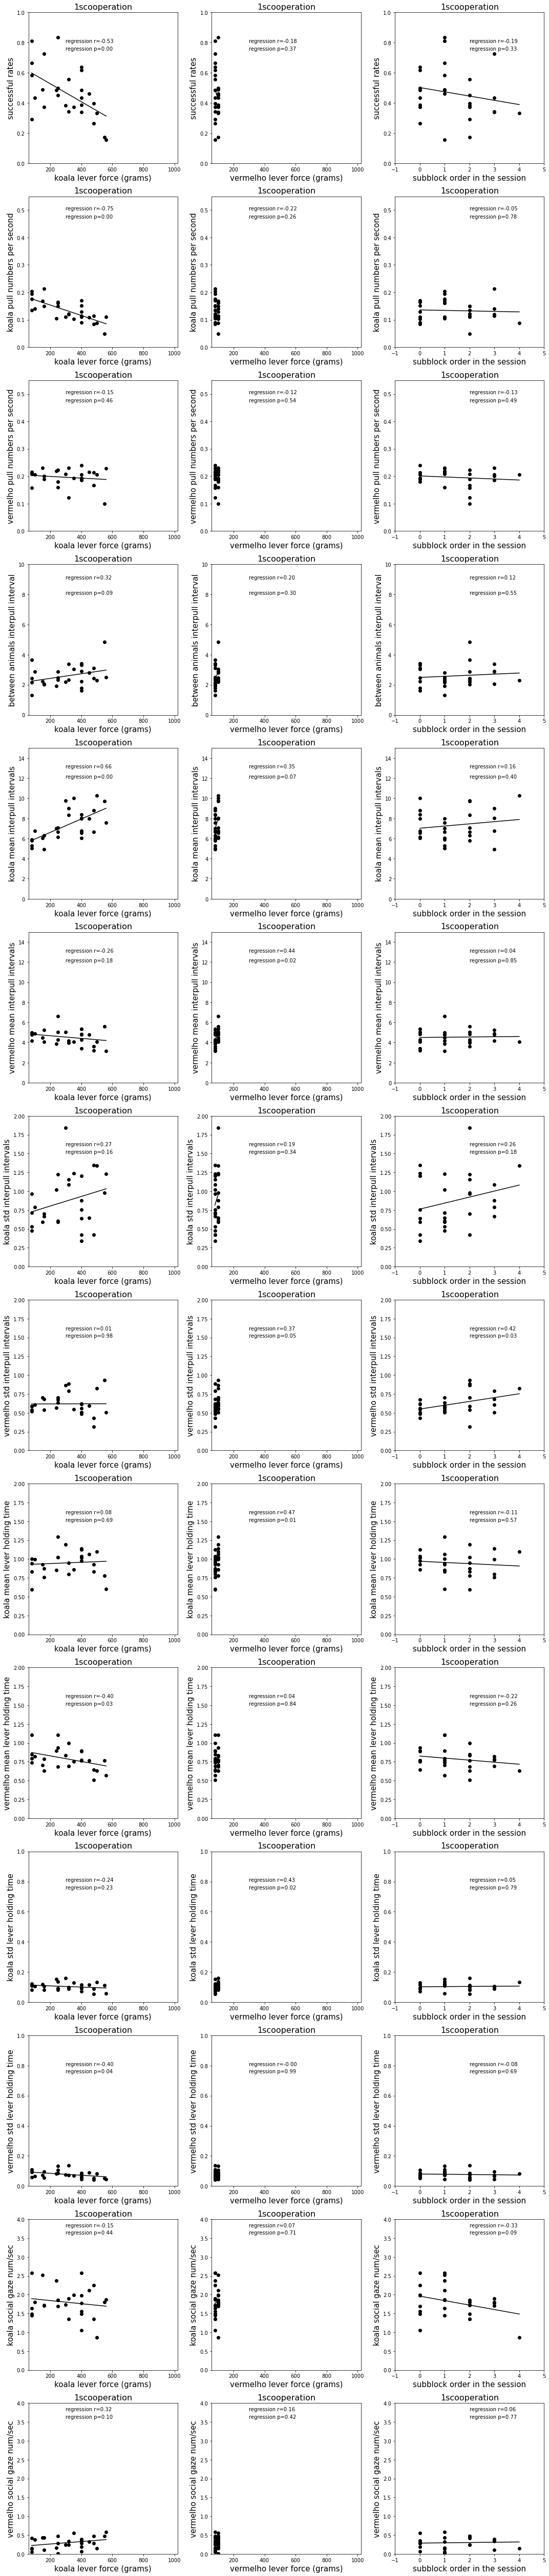

In [106]:
fig, axs = plt.subplots(14,3)
fig.set_figheight(5*14)
fig.set_figwidth(5*3)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.80, 0.50, 0.50, 9, 13, 13, 1.60, 1.60, 1.60, 1.60, 0.80, 0.80, 3.80, 3.80, ]
ytxtlocs2 = [0.75, 0.47, 0.47, 8, 12, 12, 1.50, 1.50, 1.50, 1.50, 0.75, 0.75, 3.60, 3.60, ]
yminlims = [0,   0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
ymaxlims = [1,0.55,0.55,10,15,15, 2, 2, 2, 2, 1, 1, 4, 4,]

for iytype in np.arange(0,14,1):
    
    try:
        if iytype == 0:
            yyy = succ_rate_all_dates[ind_forplot]
        elif iytype == 1:
            yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
        elif iytype == 2:
            yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
        elif iytype == 3:
            yyy = interpullintv_all_dates[ind_forplot]
        elif iytype == 4:
            yyy = pull1_IPI_all_dates[ind_forplot]
        elif iytype == 5:
            yyy = pull2_IPI_all_dates[ind_forplot]
        elif iytype == 6:
            yyy = pull1_IPI_std_all_dates[ind_forplot]
        elif iytype == 7:
            yyy = pull2_IPI_std_all_dates[ind_forplot]
        elif iytype == 8:
            yyy = lever1_holdtime_all_dates[ind_forplot]
        elif iytype == 9:
            yyy = lever2_holdtime_all_dates[ind_forplot]
        elif iytype == 10:
            yyy = lever1_holdtime_std_all_dates[ind_forplot]
        elif iytype == 11:
            yyy = lever2_holdtime_std_all_dates[ind_forplot]
        elif iytype == 12:
            yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
        elif iytype == 13:
            yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]

        # subplot 1
        xxx = force1_all_dates[ind_forplot]
        #
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
        axs[iytype,0].text(300,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
        axs[iytype,0].text(300,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
        axs[iytype,0].plot(xxx,yyy,'ko')
        axs[iytype,0].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
        axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
        axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
        axs[iytype,0].set_title(conditiontype, fontsize=16)
        axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
        axs[iytype,0].set_xlim(60,1020)

        # subplot 2
        xxx = force2_all_dates[ind_forplot]
        #
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
        axs[iytype,1].text(300,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
        axs[iytype,1].text(300,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
        axs[iytype,1].plot(xxx,yyy,'ko')
        axs[iytype,1].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
        axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
        axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
        axs[iytype,1].set_title(conditiontype, fontsize=16)
        axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
        axs[iytype,1].set_xlim(60,1020)

        # subplot 3
        xxx = subblockID_all_dates[ind_forplot]
        #
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
        axs[iytype,2].text(2,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
        axs[iytype,2].text(2,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
        axs[iytype,2].plot(xxx,yyy,'ko')
        axs[iytype,2].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
        axs[iytype,2].set_xlabel('subblock order in the session',fontsize=15)
        axs[iytype,2].set_ylabel(yaxislabels[iytype],fontsize=15)
        axs[iytype,2].set_title(conditiontype, fontsize=16)
        axs[iytype,2].set_ylim(yminlims[iytype],ymaxlims[iytype])
        axs[iytype,2].set_xlim(-1,5)
    
    except:
        continue
    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### regress against subblock ID first, and then plot the residual against force1 and force2

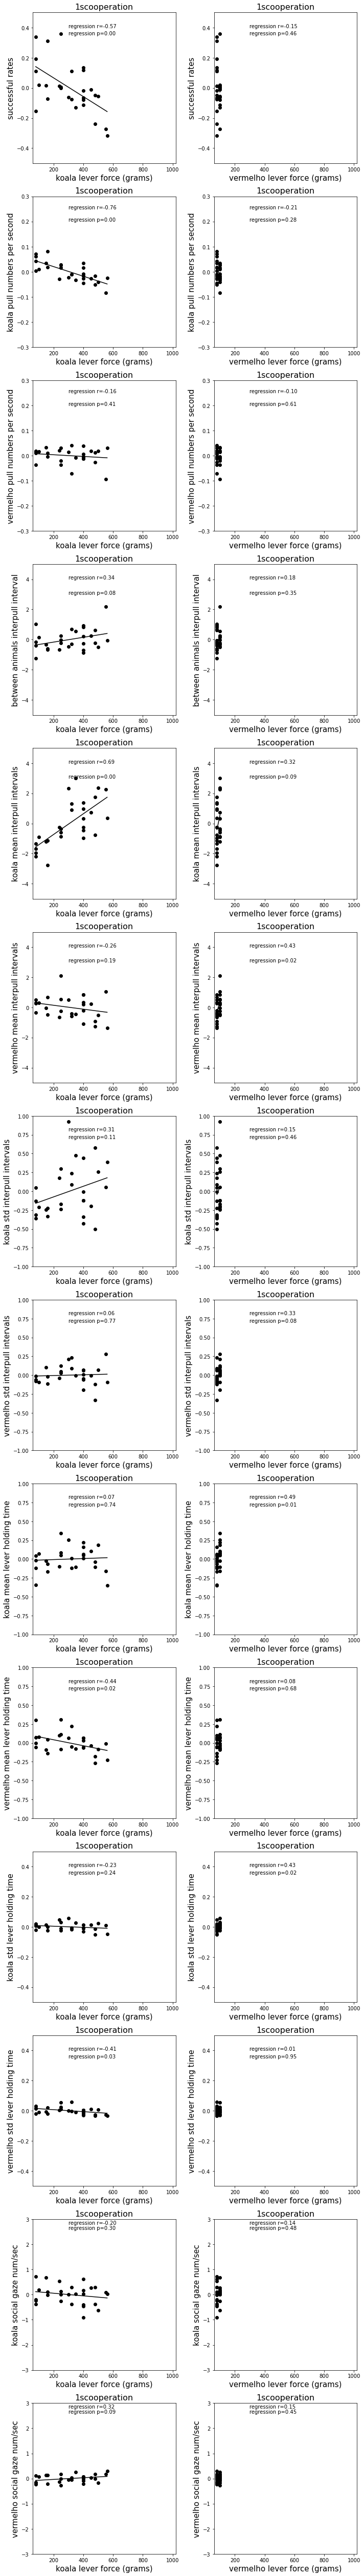

In [107]:
fig, axs = plt.subplots(14,2)
fig.set_figheight(5*14)
fig.set_figwidth(5*2)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#    ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.40, 0.25, 0.25, 4, 4, 4, 0.8, 0.8, 0.8, 0.8, 0.40, 0.40, 2.80, 2.80, ]
ytxtlocs2 = [0.35, 0.20, 0.20, 3, 3, 3, 0.7, 0.7, 0.7, 0.7, 0.35, 0.35, 2.60, 2.60, ]
yminlims = [-0.5,-0.3,-0.3,-5,-5,-5,-1,-1,-1,-1,-0.5,-0.5, -3, -3,]
ymaxlims = [ 0.5, 0.3, 0.3, 5, 5, 5, 1, 1, 1, 1, 0.5, 0.5,  3,  3,]


for iytype in np.arange(0,14,1):
    
    try:
        if iytype == 0:
            yyy = succ_rate_all_dates[ind_forplot]
        elif iytype == 1:
            yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
        elif iytype == 2:
            yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
        elif iytype == 3:
            yyy = interpullintv_all_dates[ind_forplot]
        elif iytype == 4:
            yyy = pull1_IPI_all_dates[ind_forplot]
        elif iytype == 5:
            yyy = pull2_IPI_all_dates[ind_forplot]
        elif iytype == 6:
            yyy = pull1_IPI_std_all_dates[ind_forplot]
        elif iytype == 7:
            yyy = pull2_IPI_std_all_dates[ind_forplot]
        elif iytype == 8:
            yyy = lever1_holdtime_all_dates[ind_forplot]
        elif iytype == 9:
            yyy = lever2_holdtime_all_dates[ind_forplot]
        elif iytype == 10:
            yyy = lever1_holdtime_std_all_dates[ind_forplot]
        elif iytype == 11:
            yyy = lever2_holdtime_std_all_dates[ind_forplot]
        elif iytype == 12:
            yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
        elif iytype == 13:
            yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
            
        # regress again subblock ID first
        xxx = subblockID_all_dates[ind_forplot]
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
        # 
        yyy_res = yyy - (xxx*slope+intercept)
        
        # subplot 1
        xxx = force1_all_dates[ind_forplot]
        #
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy_res)
        axs[iytype,0].text(300,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
        axs[iytype,0].text(300,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
        axs[iytype,0].plot(xxx,yyy_res,'ko')
        axs[iytype,0].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
        axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
        axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
        axs[iytype,0].set_title(conditiontype, fontsize=16)
        axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
        axs[iytype,0].set_xlim(60,1020)

        # subplot 2
        xxx = force2_all_dates[ind_forplot]
        #
        slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy_res)
        axs[iytype,1].text(300,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
        axs[iytype,1].text(300,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
        axs[iytype,1].plot(xxx,yyy_res,'ko')
        axs[iytype,1].plot(np.array([xxx.min(),xxx.max()]),np.array([xxx.min(),xxx.max()])*slope+intercept,'k-')
        axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
        axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
        axs[iytype,1].set_title(conditiontype, fontsize=16)
        axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
        axs[iytype,1].set_xlim(60,1020)

        
    
    except:
        continue
    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"subblockIDregressedResidual_forcelevel_successfulrate_pullnumbers_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### regress (>2) or connect (2) trial types in each session

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/s

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/s

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/s

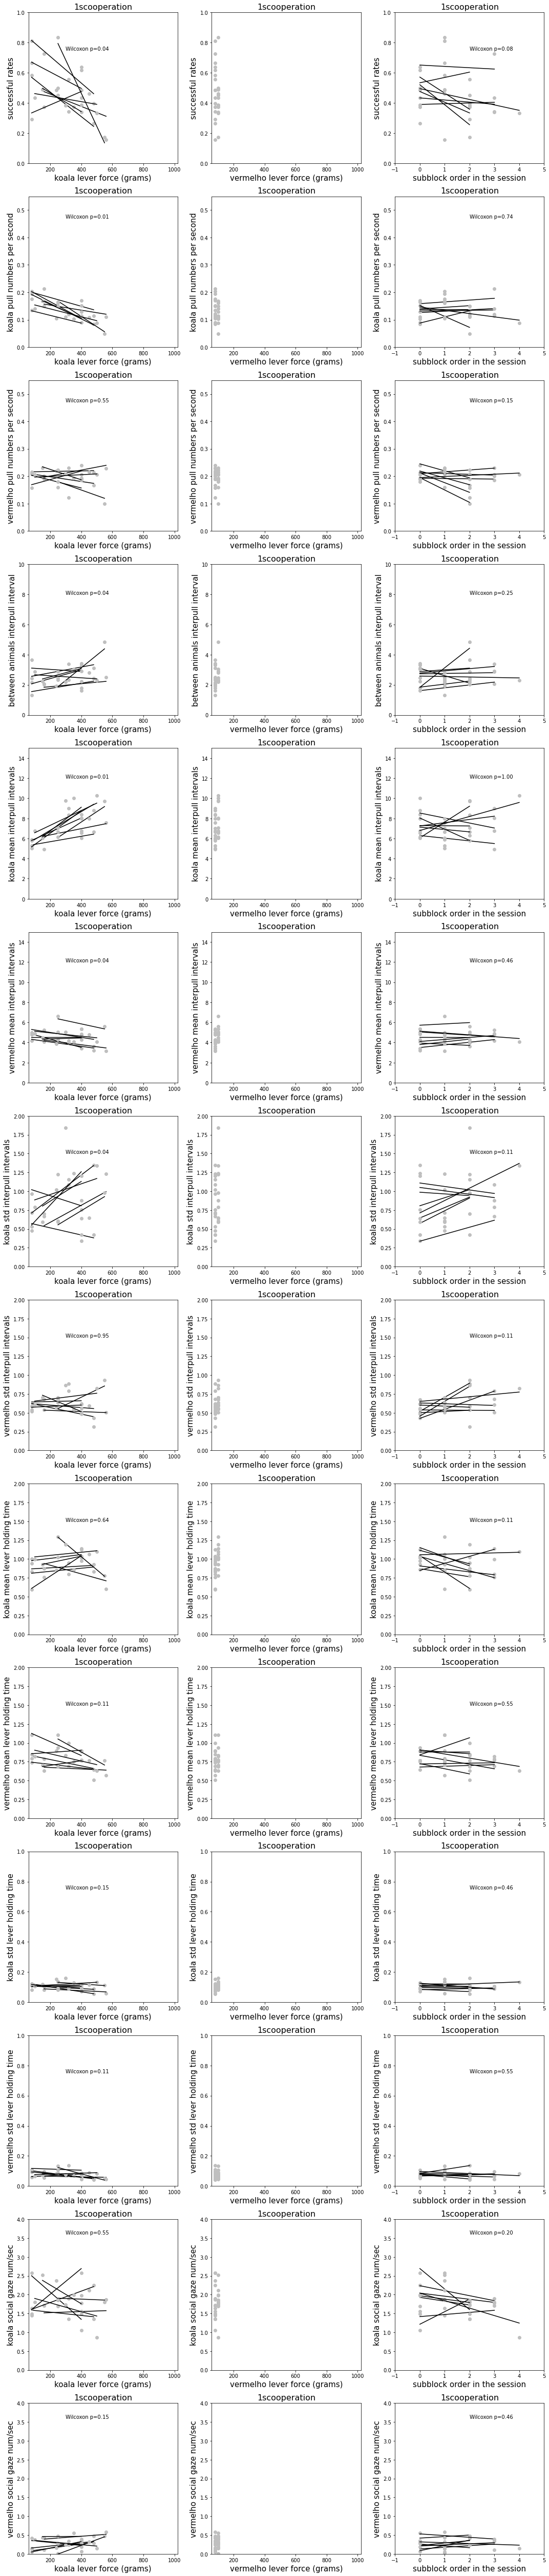

In [108]:
fig, axs = plt.subplots(14,3)
fig.set_figheight(5*14)
fig.set_figwidth(5*3)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.80, 0.50, 0.50, 9, 13, 13, 1.60, 1.60, 1.60, 1.60, 0.80, 0.80, 3.80, 3.80, ]
ytxtlocs2 = [0.75, 0.47, 0.47, 8, 12, 12, 1.50, 1.50, 1.50, 1.50, 0.75, 0.75, 3.60, 3.60, ]
yminlims = [0,   0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
ymaxlims = [1,0.55,0.55,10,15,15, 2, 2, 2, 2, 1, 1, 4, 4,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
slopes1_all_dates = np.ones((1,ntrialdates_forplot))[0]*np.nan
slopes2_all_dates = np.ones((1,ntrialdates_forplot))[0]*np.nan
slopes3_all_dates = np.ones((1,ntrialdates_forplot))[0]*np.nan

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
           

    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        if np.sum(ind_idate)>1:

            yyy_idate = yyy[ind_idate]
            
            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            slopes1_all_dates[idate] = slope
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(60,1020)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            slopes2_all_dates[idate] = slope
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(60,1020)

            # subplot 3
            xxx = subblockID_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            slopes3_all_dates[idate] = slope
            axs[iytype,2].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,2].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,2].set_xlabel('subblock order in the session',fontsize=15)
            axs[iytype,2].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,2].set_title(conditiontype, fontsize=16)
            axs[iytype,2].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,2].set_xlim(-1,5)
  
    # add the statitics for the slope
    for iplot in np.arange(0,3,1):
        try:
            # subplot 1
            if iplot == 0:
                pp = st.wilcoxon(slopes1_all_dates[~np.isnan(slopes1_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                axs[iytype,0].text(300,ytxtlocs2[iytype],'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
            # subplot 2
            elif iplot == 1:
                pp = st.wilcoxon(slopes2_all_dates[~np.isnan(slopes2_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue    
                axs[iytype,1].text(300,ytxtlocs2[iytype],'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
            # subplot 3
            elif iplot == 2:
                pp = st.wilcoxon(slopes3_all_dates[~np.isnan(slopes3_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                axs[iytype,2].text(2.0,ytxtlocs2[iytype],'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
        except:
            continue
    
    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_separatedays_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### regress against subblock ID first, and then plot the residual against force1 and force2 and separate each day (session);
#### regress (>2) or connect (2) trial types in each session

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/s

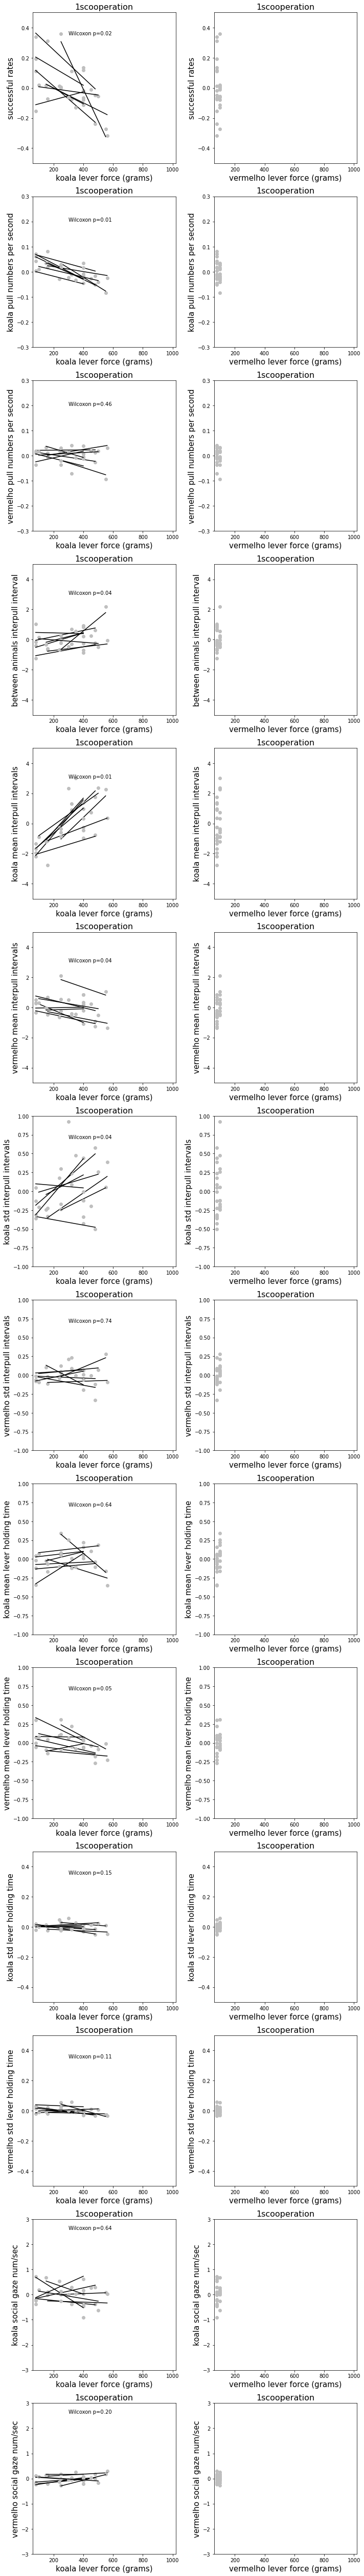

In [109]:
fig, axs = plt.subplots(14,2)
fig.set_figheight(5*14)
fig.set_figwidth(5*2)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#    ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.40, 0.25, 0.25, 4, 4, 4, 0.8, 0.8, 0.8, 0.8, 0.40, 0.40, 2.80, 2.80, ]
ytxtlocs2 = [0.35, 0.20, 0.20, 3, 3, 3, 0.7, 0.7, 0.7, 0.7, 0.35, 0.35, 2.60, 2.60, ]
yminlims = [-0.5,-0.3,-0.3,-5,-5,-5,-1,-1,-1,-1,-0.5,-0.5, -3, -3,]
ymaxlims = [ 0.5, 0.3, 0.3, 5, 5, 5, 1, 1, 1, 1, 0.5, 0.5,  3,  3,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

#
slopes1_all_dates = np.ones((1,ntrialdates_forplot))[0]*np.nan
slopes2_all_dates = np.ones((1,ntrialdates_forplot))[0]*np.nan

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
        
    
    # regress again subblock ID first
    xxx = subblockID_all_dates[ind_forplot]
    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
    # 
    yyy_res = yyy - (xxx*slope+intercept)

    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)

        if np.sum(ind_idate)>1:

            yyy_idate = yyy_res[ind_idate]

            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            slopes1_all_dates[idate] = slope
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color='0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(60,1020)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            slopes2_all_dates[idate] = slope
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color='0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(60,1020)

    # add the statitics for the slope
    # add the statitics for the slope
    for iplot in np.arange(0,3,1):
        try:
            # subplot 1
            if iplot == 0:
                pp = st.wilcoxon(slopes1_all_dates[~np.isnan(slopes1_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue
                axs[iytype,0].text(300,ytxtlocs2[iytype],'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
            # subplot 2
            elif iplot == 1:
                pp = st.wilcoxon(slopes2_all_dates[~np.isnan(slopes2_all_dates)], zero_method='wilcox', correction=False, alternative='two-sided').pvalue    
                axs[iytype,1].text(300,ytxtlocs2[iytype],'Wilcoxon p='+"{:.2f}".format(pp),fontsize=10)
        except:
            continue
        
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"subblockIDregressedResidual_forcelevel_successfulrate_pullnumbers_separatedays_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### translate the force into the reference force; two types of referece: 1) refer to the first force level

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLAB

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLAB

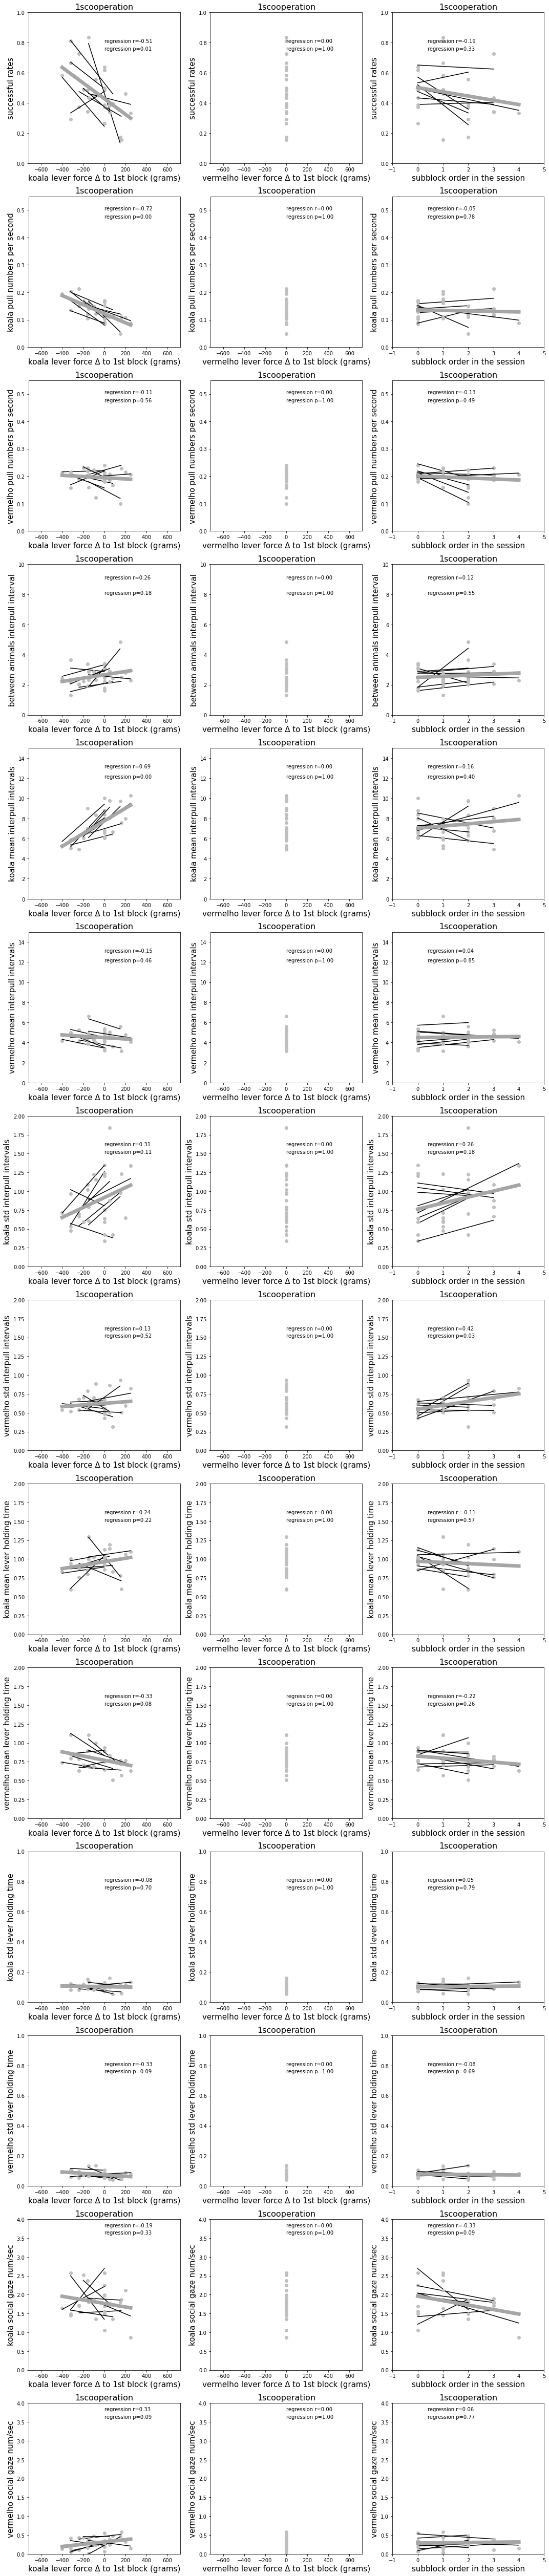

In [110]:
fig, axs = plt.subplots(14,3)
fig.set_figheight(5*14)
fig.set_figwidth(5*3)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.80, 0.50, 0.50, 9, 13, 13, 1.60, 1.60, 1.60, 1.60, 0.80, 0.80, 3.80, 3.80, ]
ytxtlocs2 = [0.75, 0.47, 0.47, 8, 12, 12, 1.50, 1.50, 1.50, 1.50, 0.75, 0.75, 3.60, 3.60, ]
yminlims = [0,   0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
ymaxlims = [1,0.55,0.55,10,15,15, 2, 2, 2, 2, 1, 1, 4, 4,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
        
    #    
    xxx1_delta = force1_all_dates[ind_forplot]
    xxx2_delta = force2_all_dates[ind_forplot]
    xxx3_delta = subblockID_all_dates[ind_forplot]

    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        if np.sum(ind_idate)>1:

            yyy_idate = yyy[ind_idate]
            
            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = (xxx_idate - xxx_idate[0])# /xxx_idate[0]
            xxx1_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force Δ to 1st block (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(-720,720)
            # axs[iytype,0].set_xlim(-2,2)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = (xxx_idate - xxx_idate[0])#/xxx_idate[0]
            xxx2_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force Δ to 1st block (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(-720,720)
            # axs[iytype,1].set_xlim(-2,2)

            # subplot 2
            xxx = subblockID_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,2].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,2].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,2].set_xlabel('subblock order in the session',fontsize=15)
            axs[iytype,2].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,2].set_title(conditiontype, fontsize=16)
            axs[iytype,2].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,2].set_xlim(-1,5)
 
    # regression on all new data points
    # subplot 1
    slope, intercept, rr, pp, std_err = st.linregress(xxx1_delta[~np.isnan(xxx1_delta)], yyy[[~np.isnan(xxx1_delta)]])
    axs[iytype,0].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,0].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,0].plot(np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)]),
                       np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 2
    slope, intercept, rr, pp, std_err = st.linregress(xxx2_delta[~np.isnan(xxx2_delta)], yyy[[~np.isnan(xxx2_delta)]])
    axs[iytype,1].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,1].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,1].plot(np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)]),
                       np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 3
    slope, intercept, rr, pp, std_err = st.linregress(xxx3_delta[~np.isnan(xxx3_delta)], yyy[[~np.isnan(xxx3_delta)]])
    axs[iytype,2].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,2].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,2].plot(np.array([np.nanmin(xxx3_delta),np.nanmax(xxx3_delta)]),
                       np.array([np.nanmin(xxx3_delta),np.nanmax(xxx3_delta)])*slope+intercept,'-',color='0.65',linewidth=7)

    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_separatedays_referedto1st_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### regress against subblock ID first, and then plot the residual against force1 and force2 and separate each day (session);
#### regress (>2) or connect (2) trial types in each session
#### translate the force into the reference force; two types of referece: 1) refer to the first force level

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

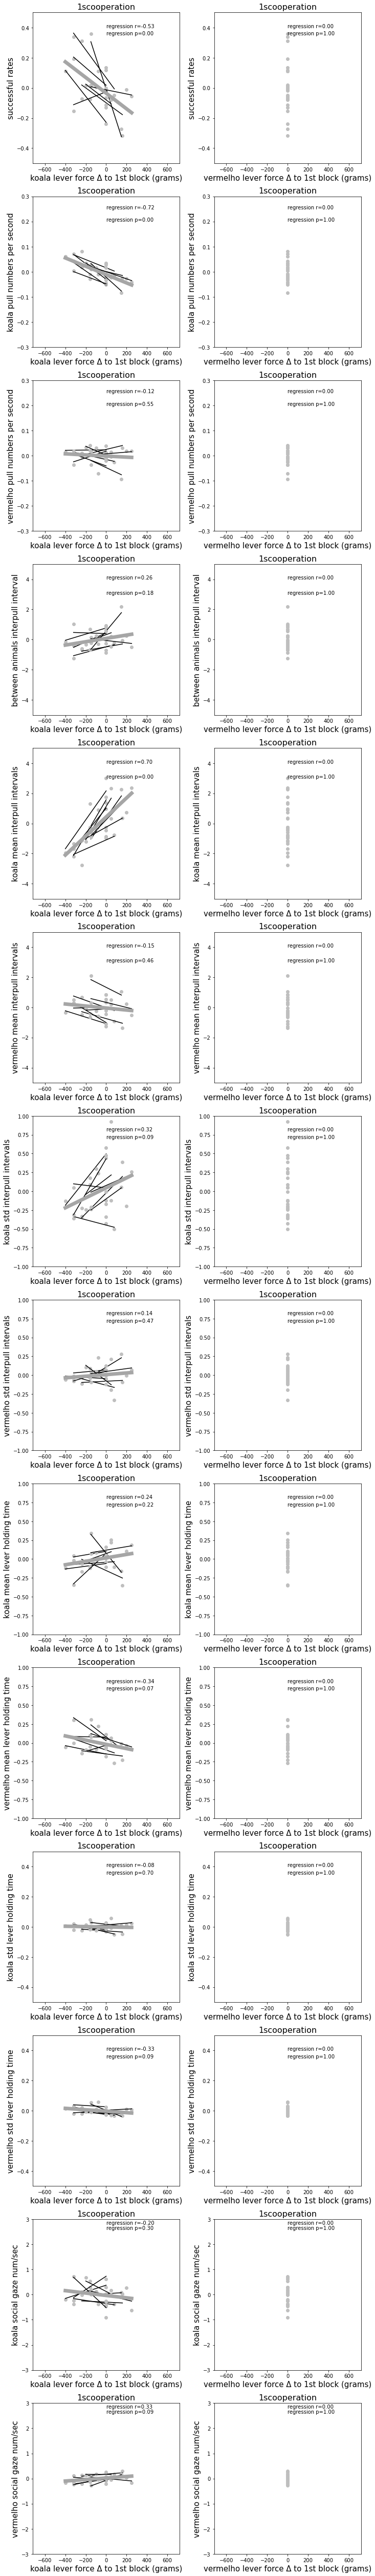

In [111]:
fig, axs = plt.subplots(14,2)
fig.set_figheight(5*14)
fig.set_figwidth(5*2)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.40, 0.25, 0.25, 4, 4, 4, 0.8, 0.8, 0.8, 0.8, 0.40, 0.40, 2.80, 2.80, ]
ytxtlocs2 = [0.35, 0.20, 0.20, 3, 3, 3, 0.7, 0.7, 0.7, 0.7, 0.35, 0.35, 2.60, 2.60, ]
yminlims = [-0.5,-0.3,-0.3,-5,-5,-5,-1,-1,-1,-1,-0.5,-0.5, -3, -3,]
ymaxlims = [ 0.5, 0.3, 0.3, 5, 5, 5, 1, 1, 1, 1, 0.5, 0.5,  3,  3,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
        
    #    
    xxx1_delta = force1_all_dates[ind_forplot]
    xxx2_delta = force2_all_dates[ind_forplot]
    
    # regress again subblock ID first
    xxx = subblockID_all_dates[ind_forplot]
    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
    # 
    yyy_res = yyy - (xxx*slope+intercept)
    
    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        if np.sum(ind_idate)>1:

            yyy_idate = yyy_res[ind_idate]
            
            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = (xxx_idate - xxx_idate[0])#/xxx_idate[0]
            xxx1_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force Δ to 1st block (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(-720,720)
            # axs[iytype,0].set_xlim(-2,2)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = (xxx_idate - xxx_idate[0])#/xxx_idate[0]
            xxx2_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force Δ to 1st block (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(-720,720)
            #axs[iytype,1].set_xlim(-2,2)
 
    # regression on all new data points
    # subplot 1
    slope, intercept, rr, pp, std_err = st.linregress(xxx1_delta[~np.isnan(xxx1_delta)], yyy_res[[~np.isnan(xxx1_delta)]])
    axs[iytype,0].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,0].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,0].plot(np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)]),
                       np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 2
    slope, intercept, rr, pp, std_err = st.linregress(xxx2_delta[~np.isnan(xxx2_delta)], yyy_res[[~np.isnan(xxx2_delta)]])
    axs[iytype,1].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,1].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,1].plot(np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)]),
                       np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)])*slope+intercept,'-',color='0.65',linewidth=7)

    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"subblockIDregressedResidual_forcelevel_successfulrate_pullnumbers_separatedays_referedto1st_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### translate the force into the reference force; two types of referece: 2) refer to the last force level

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/tmp/ipykernel_3690188/2329333669.py:142: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a

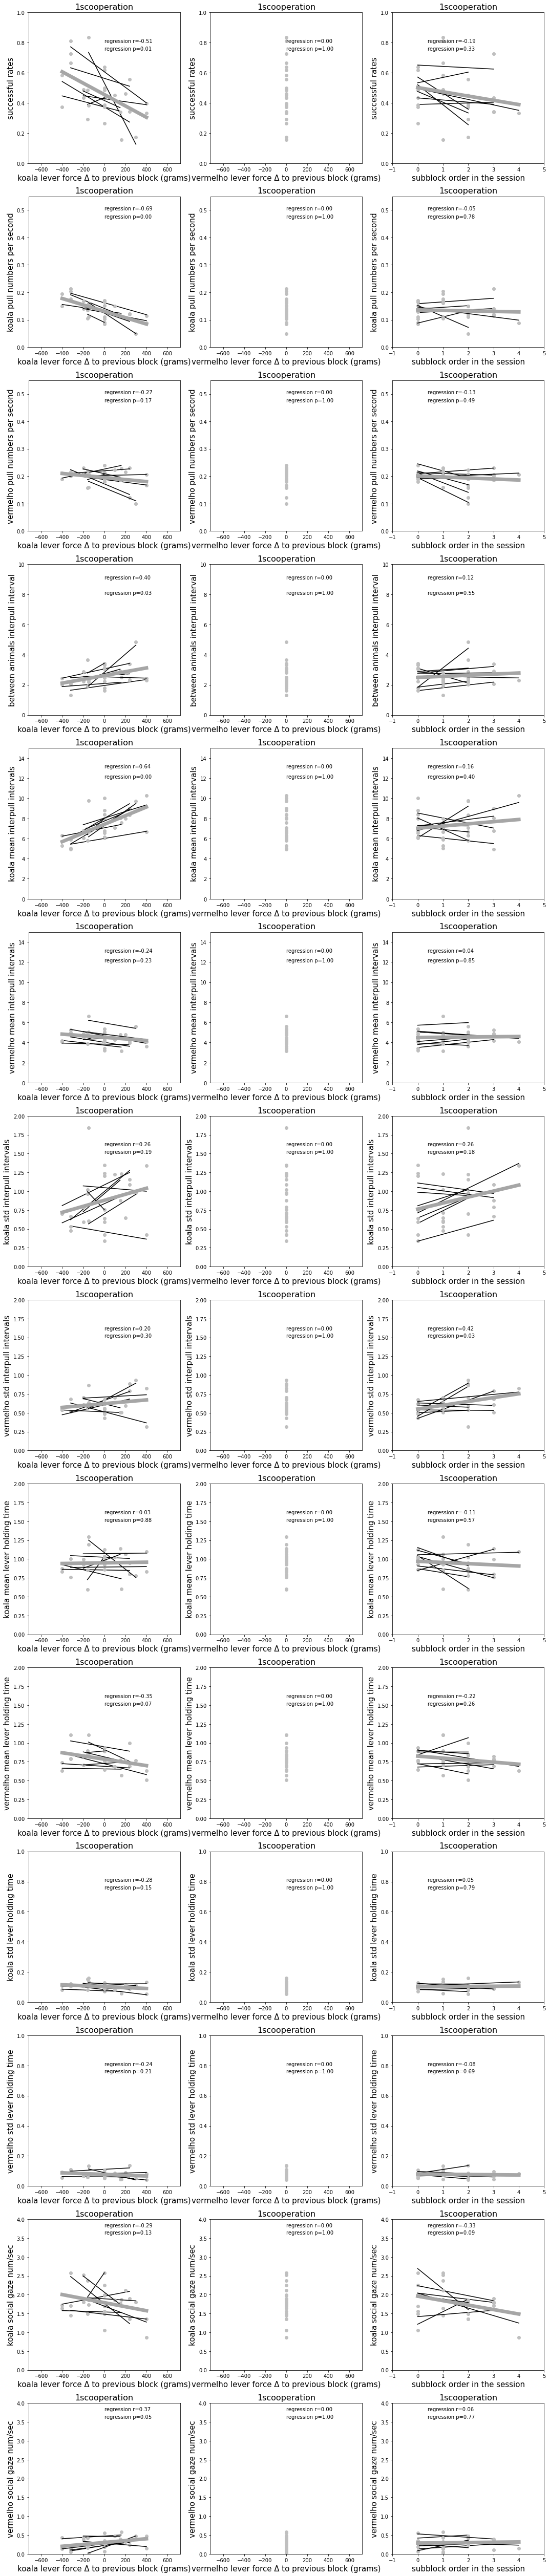

In [112]:
fig, axs = plt.subplots(14,3)
fig.set_figheight(5*14)
fig.set_figwidth(5*3)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.80, 0.50, 0.50, 9, 13, 13, 1.60, 1.60, 1.60, 1.60, 0.80, 0.80, 3.80, 3.80, ]
ytxtlocs2 = [0.75, 0.47, 0.47, 8, 12, 12, 1.50, 1.50, 1.50, 1.50, 0.75, 0.75, 3.60, 3.60, ]
yminlims = [0,   0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
ymaxlims = [1,0.55,0.55,10,15,15, 2, 2, 2, 2, 1, 1, 4, 4,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    
    #
    xxx1_delta = force1_all_dates[ind_forplot]
    xxx2_delta = force2_all_dates[ind_forplot]
    xxx3_delta = subblockID_all_dates[ind_forplot]
    
    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        if np.sum(ind_idate)>1:

            yyy_idate = yyy[ind_idate]
            
            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = xxx_idate - np.hstack((xxx_idate[0],xxx_idate[0:-1]))
            # xxx_idate = xxx_idate/np.hstack((xxx_idate[0],xxx_idate[0:-1]))-1
            # xxx_idate[(xxx_idate>5)|(xxx_idate<-5)] = np.nan # remove some outlier
            xxx1_delta[ind_idate] = xxx_idate           
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force Δ to previous block (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(-720,720)
            # axs[iytype,0].set_xlim(-4,4)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = xxx_idate - np.hstack((xxx_idate[0],xxx_idate[0:-1]))
            # xxx_idate = xxx_idate/np.hstack((xxx_idate[0],xxx_idate[0:-1]))-1
            # xxx_idate[(xxx_idate>5)|(xxx_idate<-5)] = np.nan # remove some outlier
            xxx2_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force Δ to previous block (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(-720,720)
            # axs[iytype,1].set_xlim(-4,4)

            # subplot 3
            xxx = subblockID_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,2].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,2].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,2].set_xlabel('subblock order in the session',fontsize=15)
            axs[iytype,2].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,2].set_title(conditiontype, fontsize=16)
            axs[iytype,2].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,2].set_xlim(-1,5)
    
    # regression on all new data points
    # subplot 1
    slope, intercept, rr, pp, std_err = st.linregress(xxx1_delta[~np.isnan(xxx1_delta)], yyy[[~np.isnan(xxx1_delta)]])
    axs[iytype,0].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,0].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,0].plot(np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)]),
                       np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 2
    slope, intercept, rr, pp, std_err = st.linregress(xxx2_delta[~np.isnan(xxx2_delta)], yyy[[~np.isnan(xxx2_delta)]])
    axs[iytype,1].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,1].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,1].plot(np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)]),
                       np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 3
    slope, intercept, rr, pp, std_err = st.linregress(xxx3_delta[~np.isnan(xxx3_delta)], yyy[[~np.isnan(xxx3_delta)]])
    axs[iytype,2].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,2].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,2].plot(np.array([np.nanmin(xxx3_delta),np.nanmax(xxx3_delta)]),
                       np.array([np.nanmin(xxx3_delta),np.nanmax(xxx3_delta)])*slope+intercept,'-',color='0.65',linewidth=7)

    
    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_separatedays_referedtolast_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### regress against subblock ID first, and then plot the residual against force1 and force2 and separate each day (session);
#### regress (>2) or connect (2) trial types in each session
#### translate the force into the reference force; two types of referece: 2) refer to the last force level

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packag

/tmp/ipykernel_3690188/2079143948.py:134: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  slope, intercept, rr, pp, std_err = st.linregress(xxx1_delta[~np.isnan(xxx1_delta)], yyy_res[[~np.isnan(xxx1_delta)]])
/tmp/ipykernel_3690188/2079143948.py:140: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  slope, intercept, rr, pp, std_err = st.linregress(xxx2_delta[~np.isnan(xxx2_delta)], yyy_res[[~np.isnan(xxx2_delta)]])
/gpfs/gibbs/project/nandy/ws523/conda_envs/DEEPLABCUT_YCRC/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:170: Ru

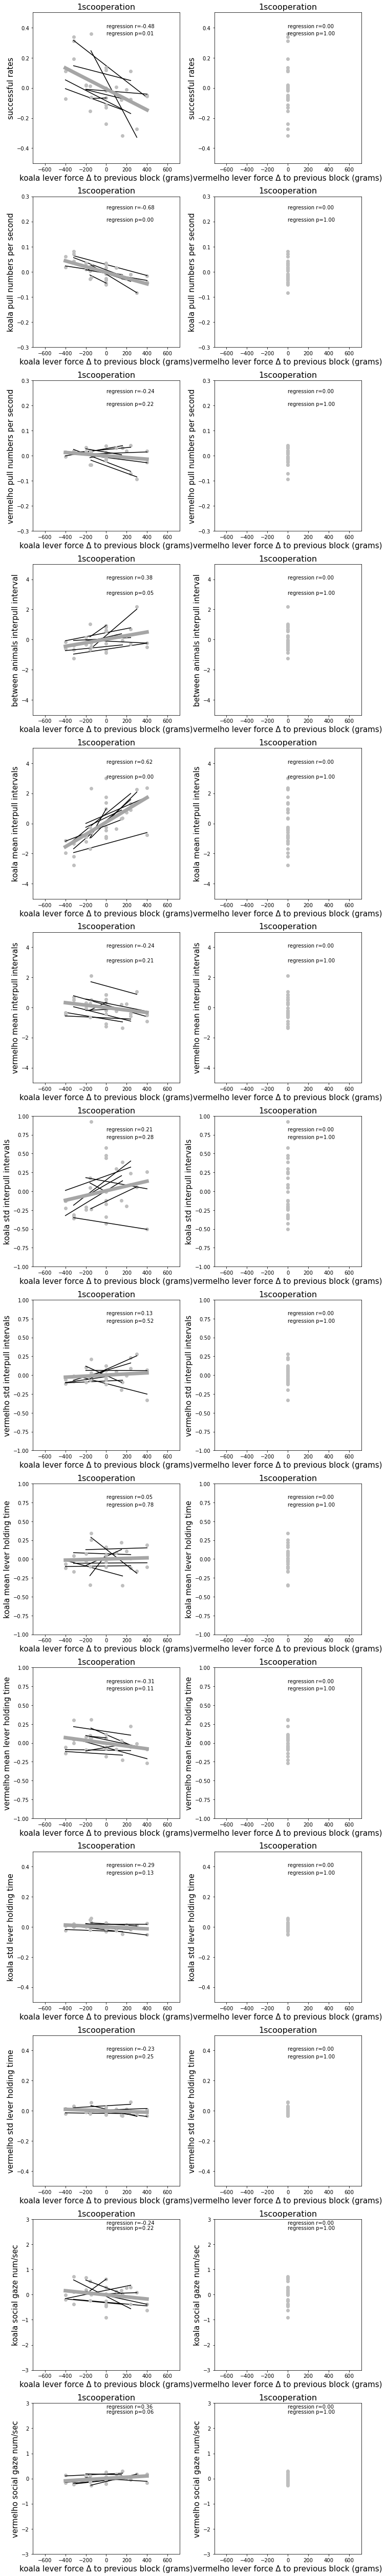

In [113]:
fig, axs = plt.subplots(14,2)
fig.set_figheight(5*14)
fig.set_figwidth(5*2)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.40, 0.25, 0.25, 4, 4, 4, 0.8, 0.8, 0.8, 0.8, 0.40, 0.40, 2.80, 2.80, ]
ytxtlocs2 = [0.35, 0.20, 0.20, 3, 3, 3, 0.7, 0.7, 0.7, 0.7, 0.35, 0.35, 2.60, 2.60, ]
yminlims = [-0.5,-0.3,-0.3,-5,-5,-5,-1,-1,-1,-1,-0.5,-0.5, -3, -3,]
ymaxlims = [ 0.5, 0.3, 0.3, 5, 5, 5, 1, 1, 1, 1, 0.5, 0.5,  3,  3,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    
    #
    xxx1_delta = force1_all_dates[ind_forplot]
    xxx2_delta = force2_all_dates[ind_forplot]
    
    # regress again subblock ID first
    xxx = subblockID_all_dates[ind_forplot]
    slope, intercept, rr, pp, std_err = st.linregress(xxx, yyy)
    # 
    yyy_res = yyy - (xxx*slope+intercept)
    
    # plot each day separately
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        if np.sum(ind_idate)>1:

            yyy_idate = yyy_res[ind_idate]
            
            # subplot 1
            xxx = force1_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = xxx_idate - np.hstack((xxx_idate[0],xxx_idate[0:-1]))
            # xxx_idate = xxx_idate/np.hstack((xxx_idate[0],xxx_idate[0:-1]))-1
            # xxx_idate[(xxx_idate>5)|(xxx_idate<-5)] = np.nan # remove some outlier
            xxx1_delta[ind_idate] = xxx_idate           
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,0].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,0].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,0].set_xlabel(animal1_fixedorder[0]+' lever force Δ to previous block (grams)',fontsize=15)
            axs[iytype,0].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,0].set_title(conditiontype, fontsize=16)
            axs[iytype,0].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,0].set_xlim(-720,720)
            # axs[iytype,0].set_xlim(-4,4)

            # subplot 2
            xxx = force2_all_dates[ind_forplot]
            xxx_idate = xxx[ind_idate]
            xxx_idate = xxx_idate - np.hstack((xxx_idate[0],xxx_idate[0:-1]))
            # xxx_idate = xxx_idate/np.hstack((xxx_idate[0],xxx_idate[0:-1]))-1
            # xxx_idate[(xxx_idate>5)|(xxx_idate<-5)] = np.nan # remove some outlier
            xxx2_delta[ind_idate] = xxx_idate 
            #
            slope, intercept, rr, pp, std_err = st.linregress(xxx_idate, yyy_idate)
            axs[iytype,1].plot(xxx_idate,yyy_idate,'o',color = '0.75')
            axs[iytype,1].plot(np.array([xxx_idate.min(),xxx_idate.max()]),
                               np.array([xxx_idate.min(),xxx_idate.max()])*slope+intercept,'k-')
            axs[iytype,1].set_xlabel(animal2_fixedorder[0]+' lever force Δ to previous block (grams)',fontsize=15)
            axs[iytype,1].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,1].set_title(conditiontype, fontsize=16)
            axs[iytype,1].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,1].set_xlim(-720,720)
            # axs[iytype,1].set_xlim(-4,4)

    
    # regression on all new data points
    # subplot 1
    slope, intercept, rr, pp, std_err = st.linregress(xxx1_delta[~np.isnan(xxx1_delta)], yyy_res[[~np.isnan(xxx1_delta)]])
    axs[iytype,0].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,0].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,0].plot(np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)]),
                       np.array([np.nanmin(xxx1_delta),np.nanmax(xxx1_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    # subplot 2
    slope, intercept, rr, pp, std_err = st.linregress(xxx2_delta[~np.isnan(xxx2_delta)], yyy_res[[~np.isnan(xxx2_delta)]])
    axs[iytype,1].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
    axs[iytype,1].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
    axs[iytype,1].plot(np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)]),
                       np.array([np.nanmin(xxx2_delta),np.nanmax(xxx2_delta)])*slope+intercept,'-',color='0.65',linewidth=7)
    
    
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"subblockIDregressedResidual_forcelevel_successfulrate_pullnumbers_separatedays_referedtolast_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

#### normalize force1 force2 and subblockID for each day (session); then do multi-variable regression


/tmp/ipykernel_3690188/1598950081.py:94: RuntimeWarning: invalid value encountered in true_divide
  xxx2_norm[ind_idate]=(xxx2_idate-np.min(xxx2_idate))/(np.max(xxx2_idate)-np.min(xxx2_idate))
/tmp/ipykernel_3690188/1598950081.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  slope, intercept, rr, pp, std_err = st.linregress(xxx_iplot[~np.isnan(xxx_iplot)], yyy_norm[[~np.isnan(xxx_iplot)]])
/tmp/ipykernel_3690188/1598950081.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  slope, intercept, rr, pp, std_err = st.linregress(xxx_iplo

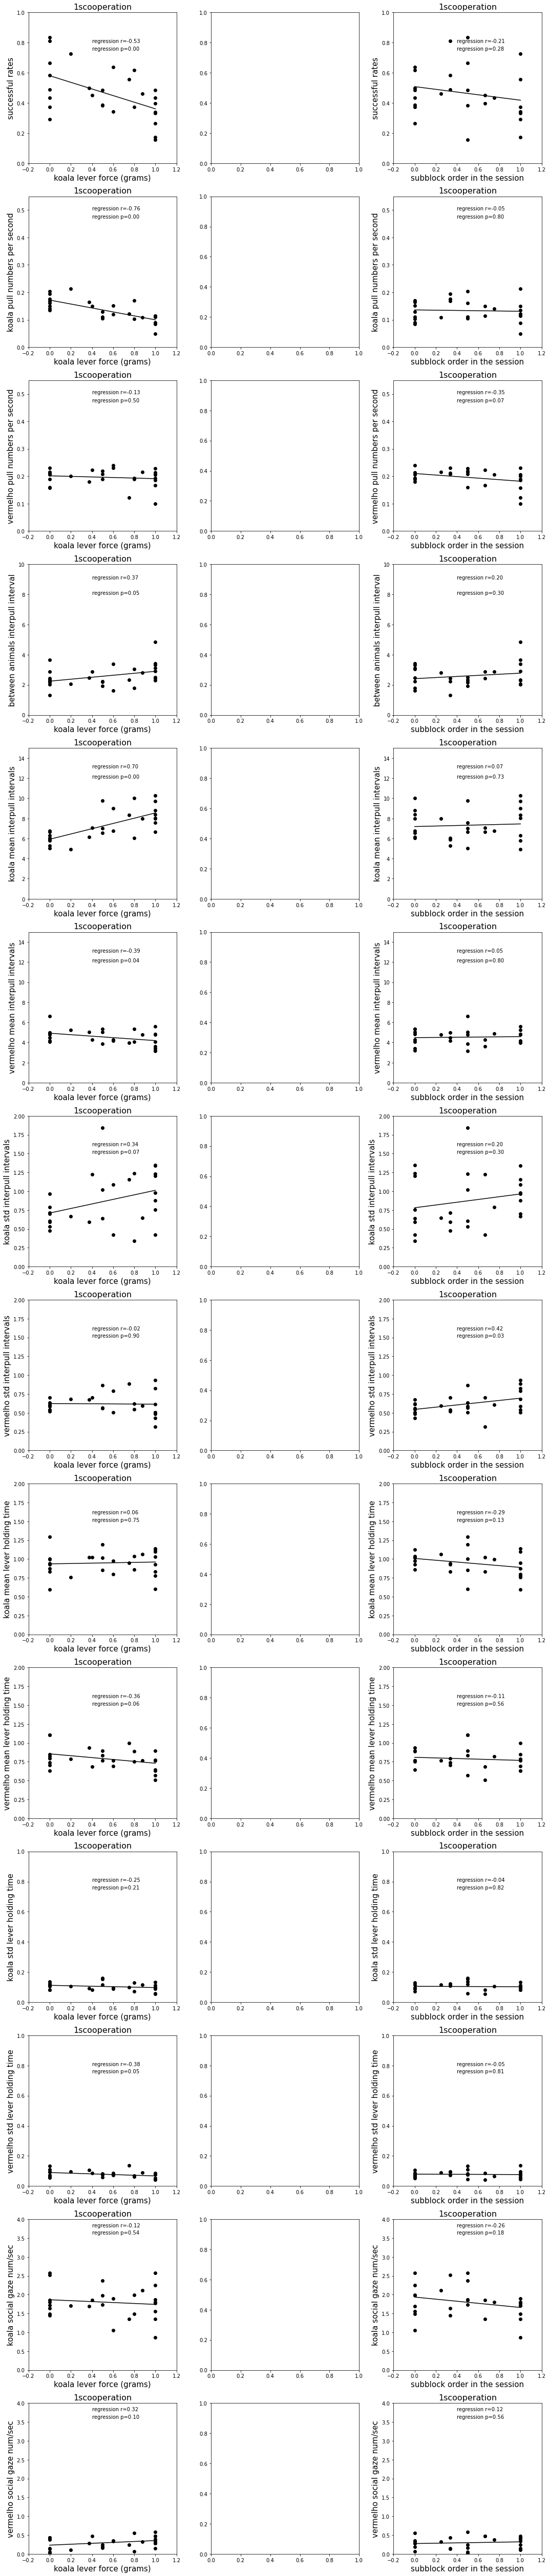

In [115]:
fig, axs = plt.subplots(14,3)
fig.set_figheight(5*14)
fig.set_figwidth(5*3)

#
ind_forplot = (trialnum_all_dates>3)  # the minimal trial number in each trial type (force level combination)
# ind_forplot = ind_forplot & (animal1_name_all_dates == 'vermelho')

if forceManiType == 'SR_bothchange':
    conditiontype = 'selfreward' # 'selfreward','1scooperation'
else:
    conditiontype = '1scooperation' # 'selfreward','1scooperation'

# if forceManiType == 'CO_A2change':
#     ind_forplot = ind_forplot & (force2_all_dates>600)
# ind_forplot = ind_forplot & (force2_all_dates>600)
    
yaxislabels = ['successful rates',
               animal1_fixedorder[0]+' pull numbers per second',
               animal2_fixedorder[0]+' pull numbers per second',
               'between animals interpull interval',
               animal1_fixedorder[0]+' mean interpull intervals',
               animal2_fixedorder[0]+' mean interpull intervals',
               animal1_fixedorder[0]+' std interpull intervals',
               animal2_fixedorder[0]+' std interpull intervals',
               animal1_fixedorder[0]+' mean lever holding time',
               animal2_fixedorder[0]+' mean lever holding time',
               animal1_fixedorder[0]+' std lever holding time',
               animal2_fixedorder[0]+' std lever holding time',
               animal1_fixedorder[0]+' social gaze num/sec',
               animal2_fixedorder[0]+' social gaze num/sec',
              ]
ytxtlocs1 = [0.80, 0.50, 0.50, 9, 13, 13, 1.60, 1.60, 1.60, 1.60, 0.80, 0.80, 3.80, 3.80, ]
ytxtlocs2 = [0.75, 0.47, 0.47, 8, 12, 12, 1.50, 1.50, 1.50, 1.50, 0.75, 0.75, 3.60, 3.60, ]
yminlims = [0,   0,   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
ymaxlims = [1,0.55,0.55,10,15,15, 2, 2, 2, 2, 1, 1, 4, 4,]

trialdates_all_dates_forplot = trialdates_all_dates[ind_forplot]
trialdates_all_dates_unique = np.unique(trialdates_all_dates_forplot)
ntrialdates_forplot = np.shape(trialdates_all_dates_unique)[0]

for iytype in np.arange(0,14,1):
    
    if iytype == 0:
        yyy = succ_rate_all_dates[ind_forplot]
    elif iytype == 1:
        yyy = pull1_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 2:
        yyy = pull2_num_all_dates[ind_forplot]/blocktime_all_dates[ind_forplot]
    elif iytype == 3:
        yyy = interpullintv_all_dates[ind_forplot]
    elif iytype == 4:
        yyy = pull1_IPI_all_dates[ind_forplot]
    elif iytype == 5:
        yyy = pull2_IPI_all_dates[ind_forplot]
    elif iytype == 6:
        yyy = pull1_IPI_std_all_dates[ind_forplot]
    elif iytype == 7:
        yyy = pull2_IPI_std_all_dates[ind_forplot]
    elif iytype == 8:
        yyy = lever1_holdtime_all_dates[ind_forplot]
    elif iytype == 9:
        yyy = lever2_holdtime_all_dates[ind_forplot]
    elif iytype == 10:
        yyy = lever1_holdtime_std_all_dates[ind_forplot]
    elif iytype == 11:
        yyy = lever2_holdtime_std_all_dates[ind_forplot]
    elif iytype == 12:
        yyy = (owgaze1_num_all_dates[ind_forplot]+mtgaze1_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    elif iytype == 13:
        yyy = (owgaze2_num_all_dates[ind_forplot]+mtgaze2_num_all_dates[ind_forplot])/blocktime_all_dates[ind_forplot]
    
    xxx1 = force1_all_dates[ind_forplot]
    xxx2 = force2_all_dates[ind_forplot]
    xxx3 = subblockID_all_dates[ind_forplot]
    
    yyy_norm = yyy
    xxx1_norm = xxx1
    xxx2_norm = xxx2
    xxx3_norm = xxx3
        
    # normalize the variables separately for each day
    for idate in np.arange(0,ntrialdates_forplot,1):
        trialdate_idate = trialdates_all_dates_unique[idate]
        
        ind_idate = np.isin(trialdates_all_dates_forplot,trialdate_idate)
        
        yyy_idate = yyy[ind_idate]
        xxx1_idate = xxx1[ind_idate]
        xxx2_idate = xxx2[ind_idate]
        xxx3_idate = xxx3[ind_idate]
        #
        xxx1_norm[ind_idate]=(xxx1_idate-np.min(xxx1_idate))/(np.max(xxx1_idate)-np.min(xxx1_idate))
        xxx2_norm[ind_idate]=(xxx2_idate-np.min(xxx2_idate))/(np.max(xxx2_idate)-np.min(xxx2_idate))
        xxx3_norm[ind_idate]=(xxx3_idate-np.min(xxx3_idate))/(np.max(xxx3_idate)-np.min(xxx3_idate))
    
    # plot three kinds of x variables
    xlabels_all = [animal1_fixedorder[0]+' lever force (grams)',
                   animal2_fixedorder[0]+' lever force (grams)',
                   'subblock order in the session',
                  ]
    
    for isubplot in np.arange(0,3,1): 
        
        if isubplot == 0:
            xxx_iplot = xxx1_norm
        elif isubplot == 1:
            xxx_iplot = xxx2_norm
        elif isubplot == 2:
            xxx_iplot = xxx3_norm
        
        try:
            # subplot 1,2,3
            slope, intercept, rr, pp, std_err = st.linregress(xxx_iplot[~np.isnan(xxx_iplot)], yyy_norm[[~np.isnan(xxx_iplot)]])
            axs[iytype,isubplot].text(0.4,ytxtlocs1[iytype],'regression r='+"{:.2f}".format(rr),fontsize=10)
            axs[iytype,isubplot].text(0.4,ytxtlocs2[iytype],'regression p='+"{:.2f}".format(pp),fontsize=10)
            axs[iytype,isubplot].plot(xxx_iplot,yyy_norm,'ko')
            axs[iytype,isubplot].plot(np.array([np.nanmin(xxx_iplot),np.nanmax(xxx_iplot)]),
                                     np.array([np.nanmin(xxx_iplot),np.nanmax(xxx_iplot)])*slope+intercept,'k-')
            axs[iytype,isubplot].set_xlabel(xlabels_all[isubplot],fontsize=15)
            axs[iytype,isubplot].set_ylabel(yaxislabels[iytype],fontsize=15)
            axs[iytype,isubplot].set_title(conditiontype, fontsize=16)
            axs[iytype,isubplot].set_ylim(yminlims[iytype],ymaxlims[iytype])
            axs[iytype,isubplot].set_xlim(-0.2,1.2)
        except:
             continue
        
fig.tight_layout()

savefigs = 1
if savefigs:
    figsavefolder = data_saved_folder+'figs_for_BasicBhvAna_singlecam_wholebodylabels_allsessions_basicEvents/'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)
    plt.savefig(figsavefolder+"forcelevel_successfulrate_pullnumbers_normalized_in_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+forceManiType+'.pdf')

In [116]:
xxx1_norm

array([0.8  , 0.   , 1.   , 0.2  , 0.6  , 1.   , 0.   , 1.   , 0.   ,
       0.6  , 1.   , 0.   , 0.75 , 1.   , 0.5  , 0.   , 0.5  , 0.   ,
       1.   , 0.8  , 0.   , 0.4  , 1.   , 0.375, 0.875, 0.5  , 0.   ,
       1.   ])